# Predicting Resolver Response Code Based on Query

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.preprocessing, sklearn.model_selection, sklearn.tree
import graphviz 
import matplotlib.pyplot as plt

In [2]:
ALGO_NAME = {
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}
# defining priority (from low to high)
priority = [ALGO_NAME[key] for key in sorted(ALGO_NAME.keys())]

## Prepare Data

In [3]:
data = {
    name: pd.read_pickle(f'ml_data_{name}.pickle')
    for name in ALGO_NAME.values()
}

In [4]:
features = list(filter(lambda c: c.startswith('feature_dns'), next(iter(data.values())).keys()))
labels = list(filter(lambda c: c.startswith('label_'), next(iter(data.values())).keys()))
label = 'label_rcode0andad1'

### Display all Features that have *any* Variability

In [5]:
features = list(filter(lambda f: f != 'feature_ip_src', features))

In [6]:
for algo, d in data.items():
    print(f'++++{algo}++++', len(d), 'total queries')
    for c in features + labels:
        u = np.unique(d[c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++rsasha1++++ 1558 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 11 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
label_rcode: 2 unique values
label_resolver: 208 unique values
label_rcode0andad1: 2 unique values
++++rsasha1nsec3sha1++++ 1482 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 10 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
label_rcode: 2 unique values
label_resolver: 189 unique values
label_rcode0andad1: 2 unique values
++++rsasha256++++ 1486 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 12 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
label_rcode: 2 unique values
label_resolver: 188 uniq

In [7]:
data['ed448'].keys()

Index(['index', 'id', 'qname', 'tag', 'started', 'server_packets', 'finished',
       'zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status',
       'resolver', 'qlabel', 'num_client_packets', 'client_query',
       'client_response', 'client_response_rcode', 'client_response_ad',
       'num_server_packets', 'server_query', 'validated_response', 'rc0&ad1',
       'rc0', 'label_rcode', 'label_resolver', 'label_rcode0andad1',
       'feature_ip_ttl', 'feature_ip_src', 'feature_ip_proto', 'feature_ip_df',
       'feature_ip_ihl', 'feature_ip_id_is_zero', 'feature_dns_qr',
       'feature_dns_opcode', 'feature_dns_aa', 'feature_dns_tc',
       'feature_dns_rd', 'feature_dns_ra', 'feature_dns_z', 'feature_dns_cd',
       'feature_dns_rcode', 'feature_dns_qdcount', 'feature_dns_ancount',
       'feature_dns_nscount', 'feature_dns_arcount',
       'feature_dns_edns_requestors_udp_payload_size', 'feature_dns_0x20',
       'feature_dns_edns_cookie', 'feature_dns_edns_subnet',
       'res

In [8]:
tdata = data['ed448'][['feature_dns_cd', 'feature_dns_edns_requestors_udp_payload_size', 'feature_dns_0x20', 'feature_dns_edns_cookie', 'feature_dns_edns_subnet', 'client_response_rcode', 'client_response_ad', 'label_rcode0andad1']]
tdata.columns = ['CD bit set', 'Advertised UDP Payload Size', 'Uses 0x20 Encoding', 'Sets EDNS Cookie', 'Advertises Subnet', 'Response Code', 'AD bit set', 'Label']
print(tdata[:25].to_latex(
    index=False,
))
tdata

\begin{tabular}{rrlllrrl}
\toprule
 CD bit set &  Advertised UDP Payload Size &  Uses 0x20 Encoding &  Sets EDNS Cookie &  Advertises Subnet &  Response Code &  AD bit set &  Label \\
\midrule
          0 &                         1452 &               False &             False &              False &              0 &           0 &  False \\
          0 &                         1452 &               False &             False &              False &              0 &           0 &  False \\
          1 &                         1410 &               False &             False &              False &              0 &           1 &   True \\
          1 &                         1410 &               False &             False &              False &              0 &           1 &   True \\
          1 &                         1400 &               False &             False &               True &              0 &           0 &  False \\
          0 &                         1680 &               Fal

,CD bit set,Advertised UDP Payload Size,Uses 0x20 Encoding,Sets EDNS Cookie,Advertises Subnet,Response Code,AD bit set,Label
48,0,1452,False,False,False,0,0,False
52,0,1452,False,False,False,0,0,False
71,1,1410,False,False,False,0,1,True
72,1,1410,False,False,False,0,1,True
100,1,1400,False,False,True,0,0,False
...,...,...,...,...,...,...,...,...
9377,0,4096,False,True,False,0,0,False
9486,0,1232,False,True,False,0,0,False
9489,0,1232,False,True,False,0,0,False
9575,1,4096,False,False,False,0,0,False


### Encode String-Based Features

In [9]:
for d in data.values():
    le_feature_ip_src = sk.preprocessing.LabelEncoder()
    le_feature_ip_src.fit(d['feature_ip_src'])
    d['feature_ip_src'] = le_feature_ip_src.transform(d['feature_ip_src'])

## Train and Evaluate Decision Tree

In [10]:
tree = {}

for algo, d in data.items():
    d['status'] = 'unassigned'
    X = d[features + ['status']]
    Y = d[label]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)
    d.loc[X_train.index, 'status'] = 'training'
    d.loc[X_test.index, 'status'] = 'test'
    X = d[features + ['status']]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)
    assert set(X_train['status']) == {'training'}
    assert set(X_test['status']) == {'test'}, set(X_test['status'])
    X = d[features]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)

    tree[algo] = sk.tree.DecisionTreeClassifier()
    tree[algo] = tree[algo].fit(X_train, Y_train)

### Evaluate Prediction Error

In [11]:
metrics = []

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X_test = d[d['status'] == 'test'][features]
        Y_test = d[d['status'] == 'test'][label]
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test) / len(Y_test)
        metrics.append({
            'algo': algo,
            'true negative': cm[0,0],
            'true positive': cm[1,1],
            'false negative': cm[0,1],
            'false positive': cm[1,0],
            'seed': seed,
        })
        
metrics = pd.DataFrame(metrics)
metrics = metrics.groupby(['algo']).mean().sort_values('algo', key=lambda r: list(map(lambda e: priority.index(e), r)))
del metrics['seed']
print(metrics.to_latex(
    float_format=lambda f: f"{f:.0%}",
))
metrics

\begin{tabular}{lrrrr}
\toprule
{} &  true negative &  true positive &  false negative &  false positive \\
algo             &                &                &                 &                 \\
\midrule
rsasha1          &            80\% &             0\% &             20\% &              0\% \\
rsasha1nsec3sha1 &            39\% &            25\% &             22\% &             14\% \\
rsasha256        &            39\% &            26\% &             22\% &             13\% \\
rsasha512        &            35\% &            26\% &             21\% &             18\% \\
ecdsap256sha256  &            30\% &            20\% &             31\% &             18\% \\
ecdsap384sha384  &            39\% &            21\% &             24\% &             16\% \\
ed25519          &            43\% &            16\% &             28\% &             13\% \\
ed448            &            86\% &             4\% &              5\% &              5\% \\
\bottomrule
\end{tabular}



,true negative,true positive,false negative,false positive
algo,,,,
rsasha1,0.797009,0.000000,0.202991,0.000000
rsasha1nsec3sha1,0.393258,0.249438,0.217978,0.139326
rsasha256,0.385650,0.260090,0.219731,0.134529
rsasha512,0.348993,0.261745,0.210291,0.178971
ecdsap256sha256,0.304000,0.200000,0.312000,0.184000
ecdsap384sha384,0.392857,0.205357,0.241071,0.160714
ed25519,0.427419,0.161290,0.282258,0.129032
ed448,0.857143,0.035714,0.053571,0.053571


In [12]:
correct = {}

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X_test = d[d['status'] == 'test'][features]
        Y_test = d[d['status'] == 'test'][label]

        #sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
        c = np.sum(np.diagonal(cm))/len(Y_test)
        title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
        correct.setdefault(algo, [c]).append(c)
        #plt.title(title)
        #print(title)
        
{
    algo: np.round(np.mean(cs), 3) for algo, cs in correct.items()
}

{'rsasha1': 0.797,
 'rsasha1nsec3sha1': 0.643,
 'rsasha256': 0.646,
 'rsasha512': 0.611,
 'ecdsap256sha256': 0.504,
 'ecdsap384sha384': 0.598,
 'ed25519': 0.589,
 'ed448': 0.893}

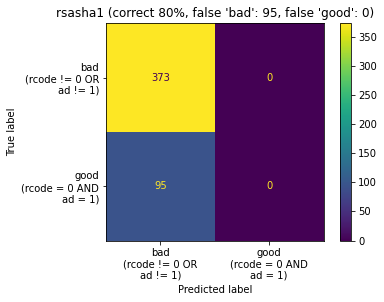

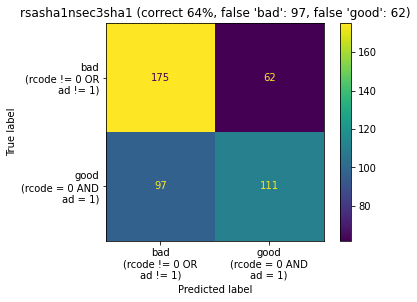

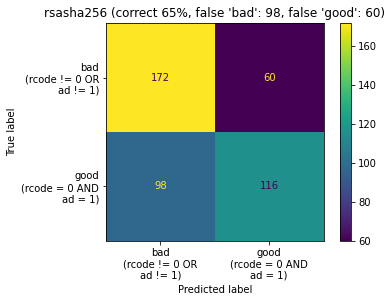

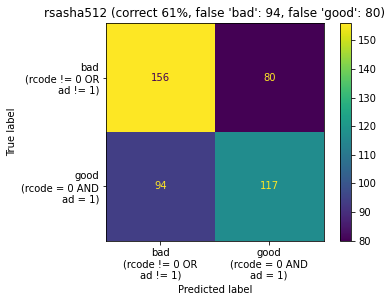

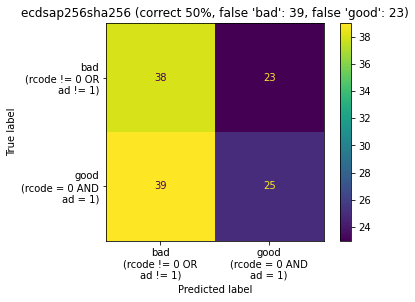

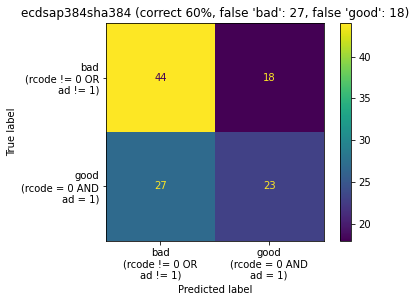

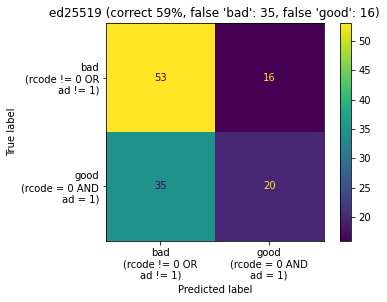

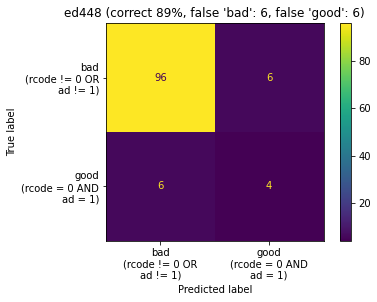

In [13]:
for algo, t in tree.items():
    d = data[algo]
    X_test = d[d['status'] == 'test'][features]
    Y_test = d[d['status'] == 'test'][label]

    sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
    cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
    c = np.sum(np.diagonal(cm))/len(Y_test)
    title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
    plt.title(title)


## Show Decision Tree

In [14]:
graphs = {}

for algo, t in tree.items():
    dot_data = sk.tree.export_graphviz(
        t, out_file=None, 
        feature_names=features,  
        class_names=['OK', 'Failure'],  
        filled=True, rounded=True,  
        special_characters=True,
        impurity=True,
    )  
    graphs[algo] = graphviz.Source(dot_data)  

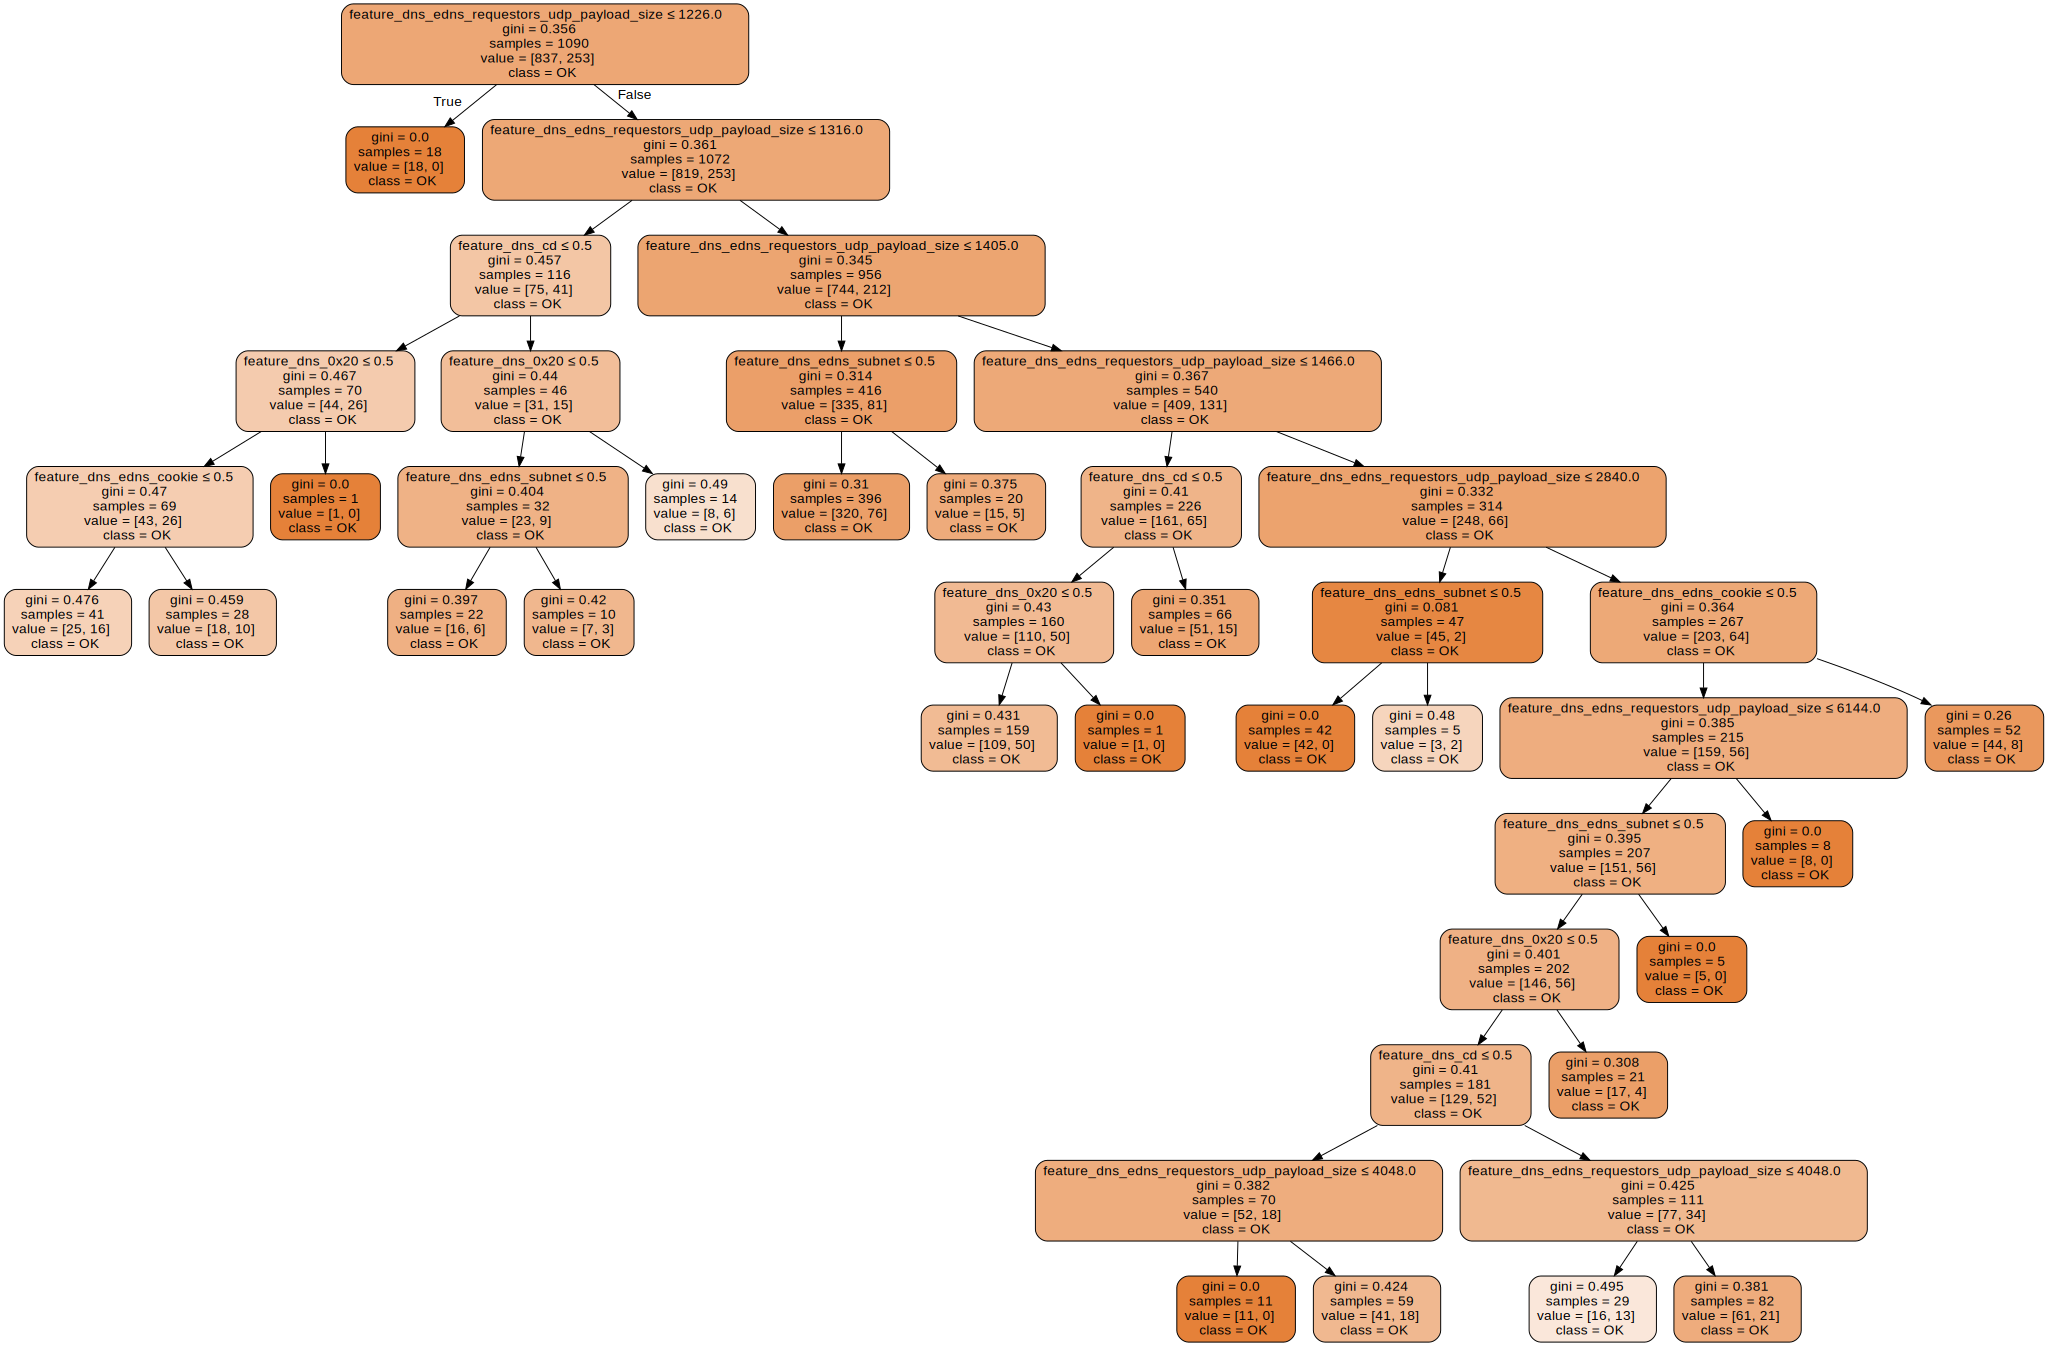

In [15]:
graphs['rsasha1']

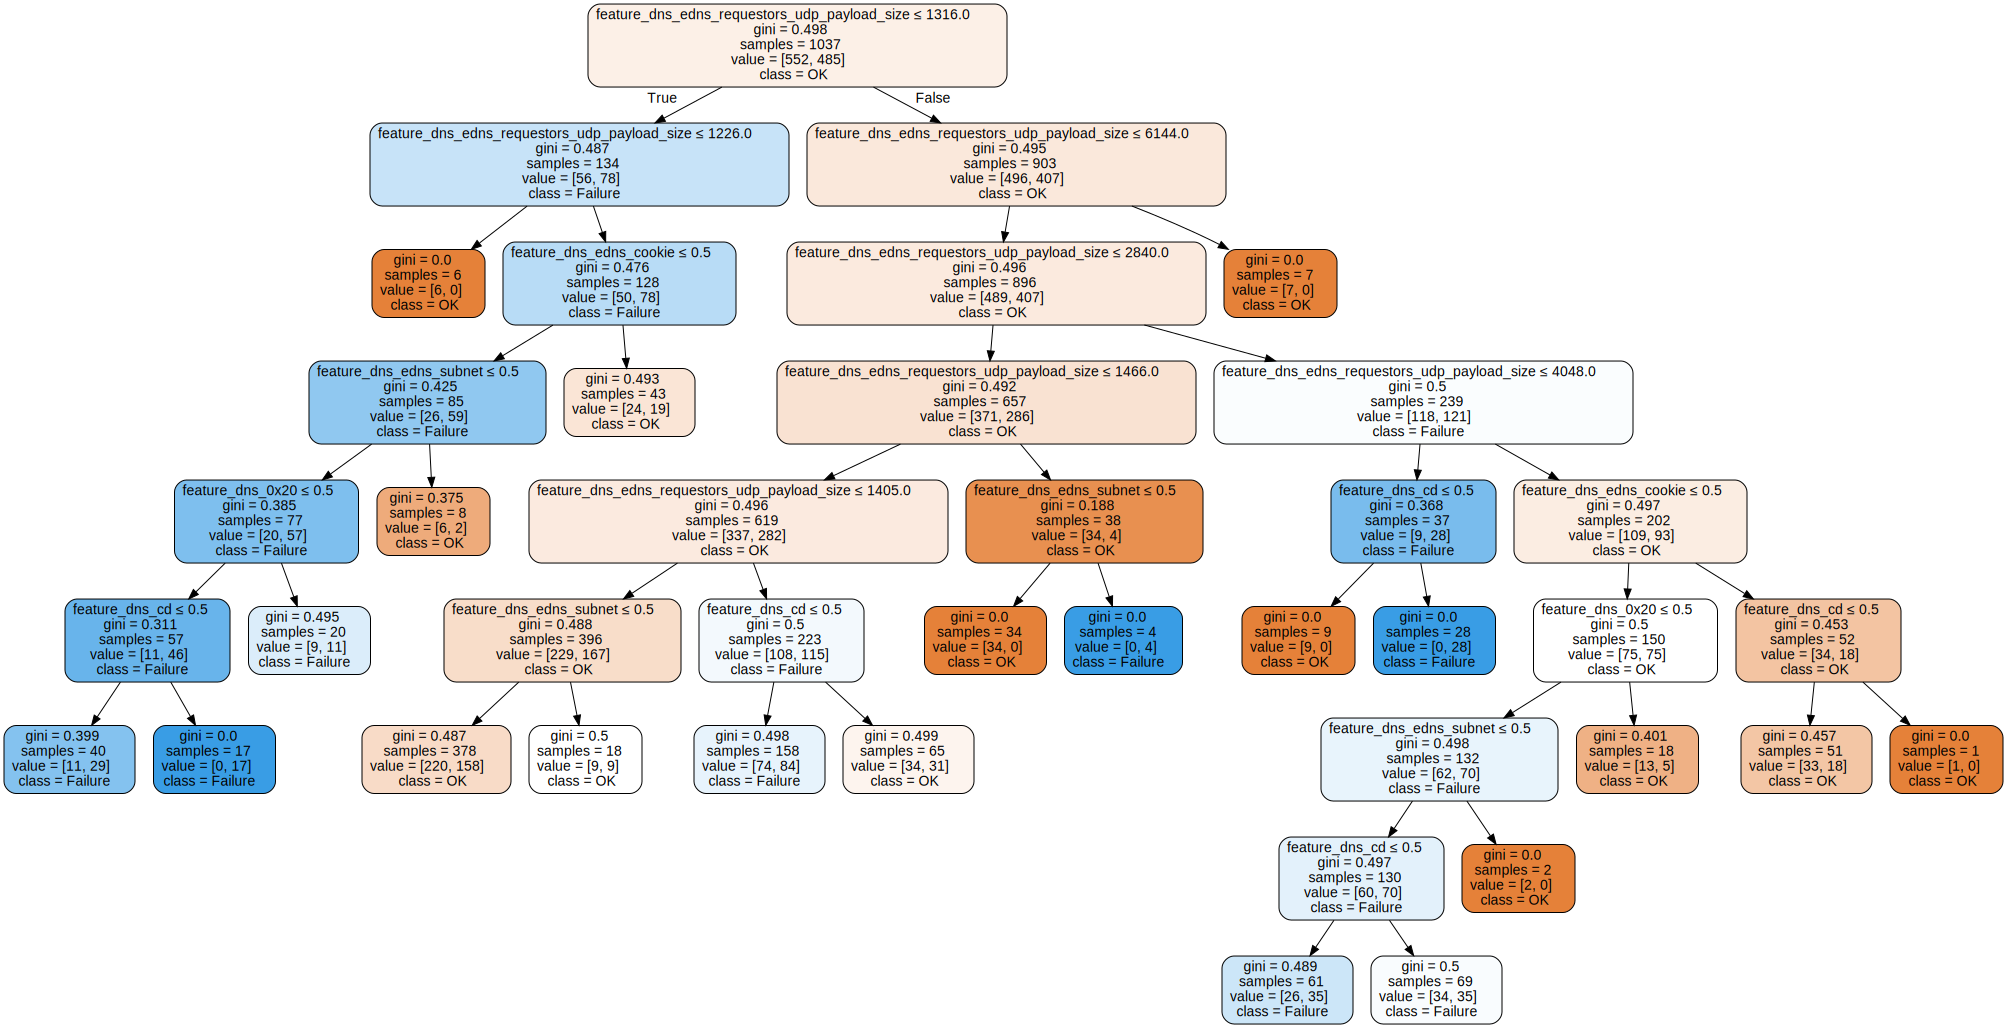

In [16]:
graphs['rsasha1nsec3sha1']

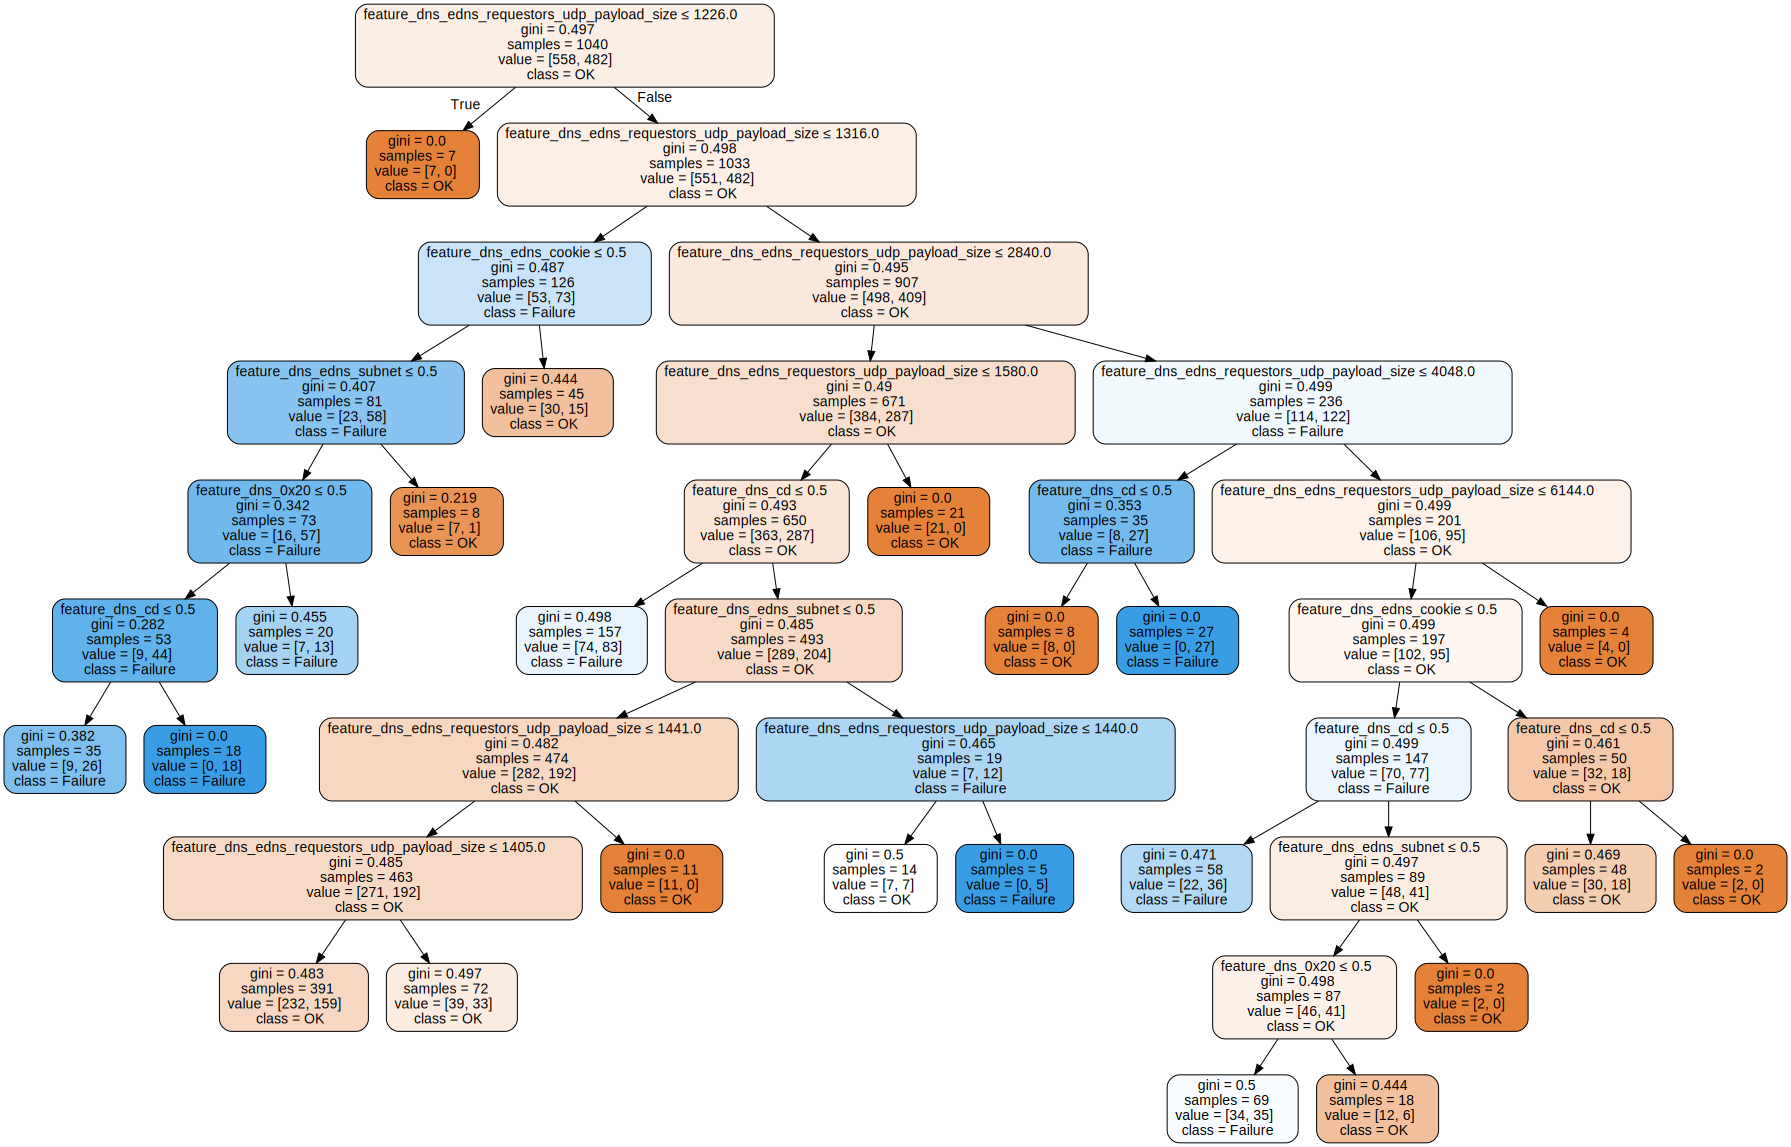

In [17]:
graphs['rsasha256']

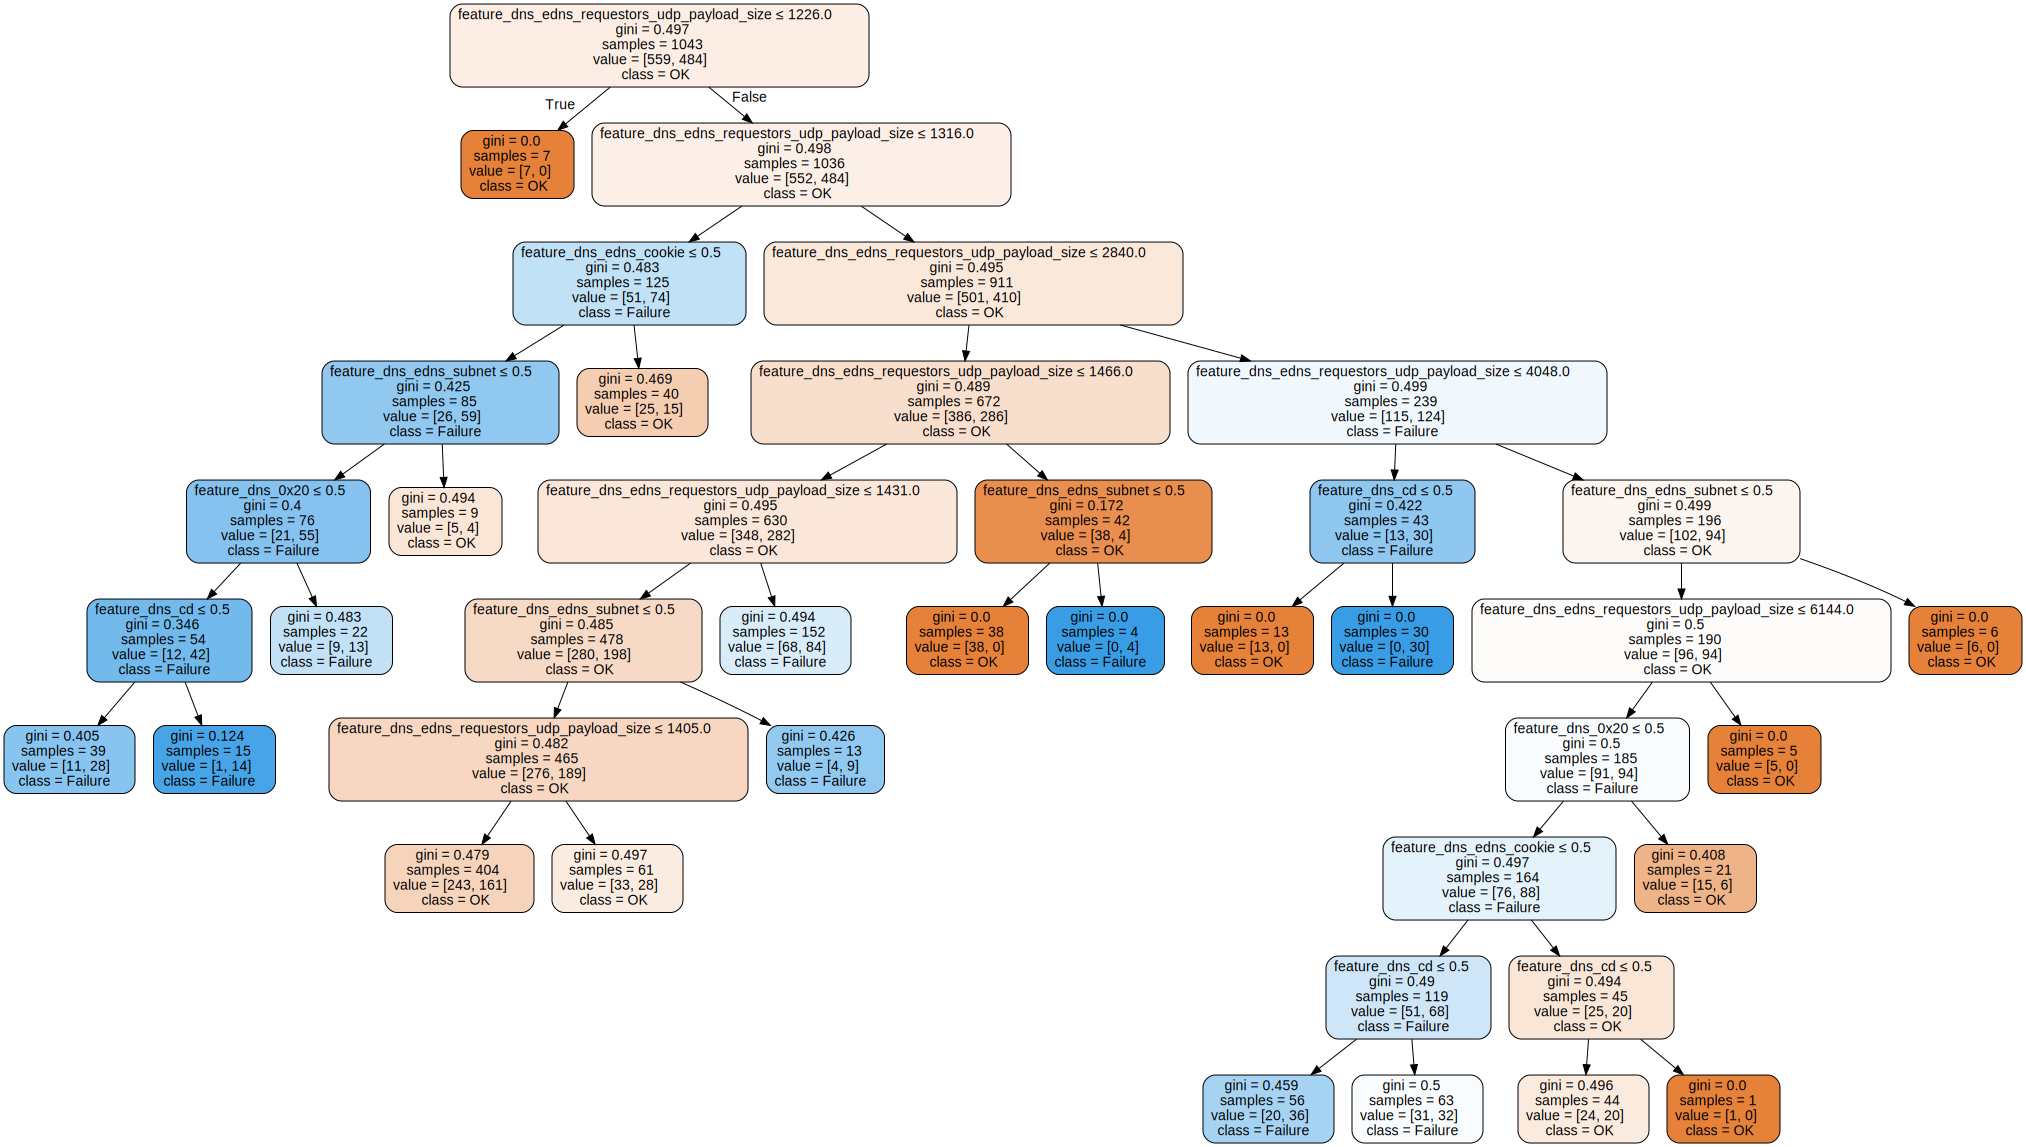

In [18]:
graphs['rsasha512']

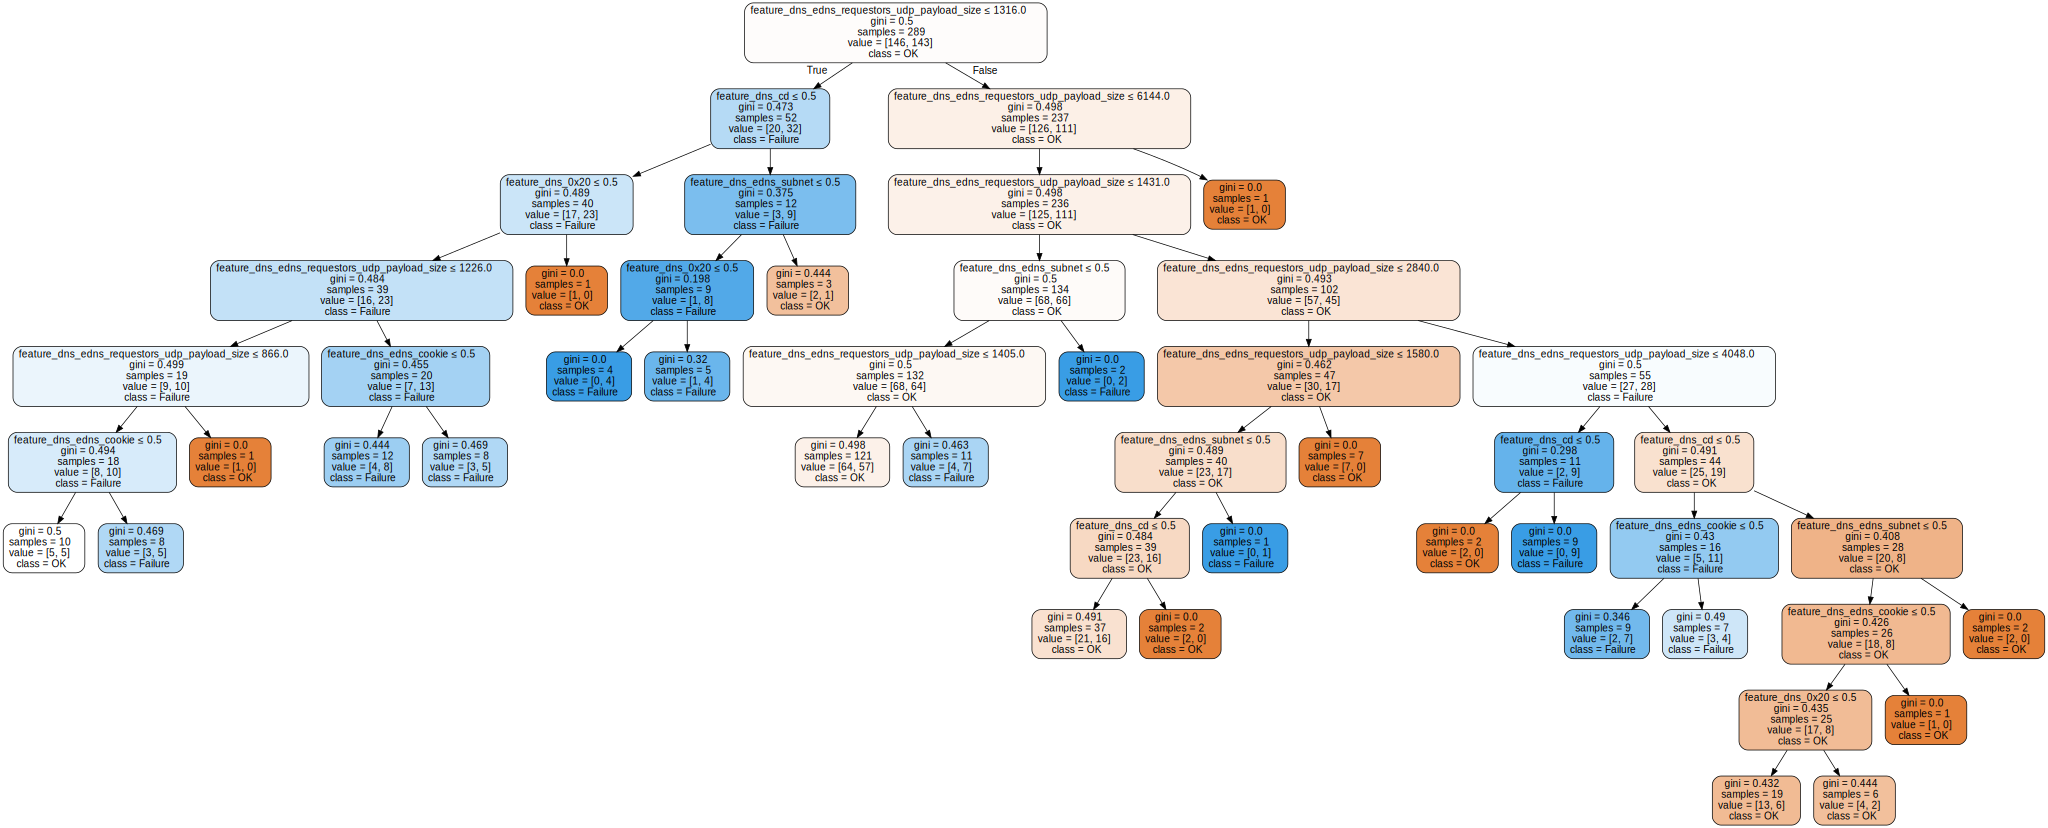

In [19]:
graphs['ecdsap256sha256']

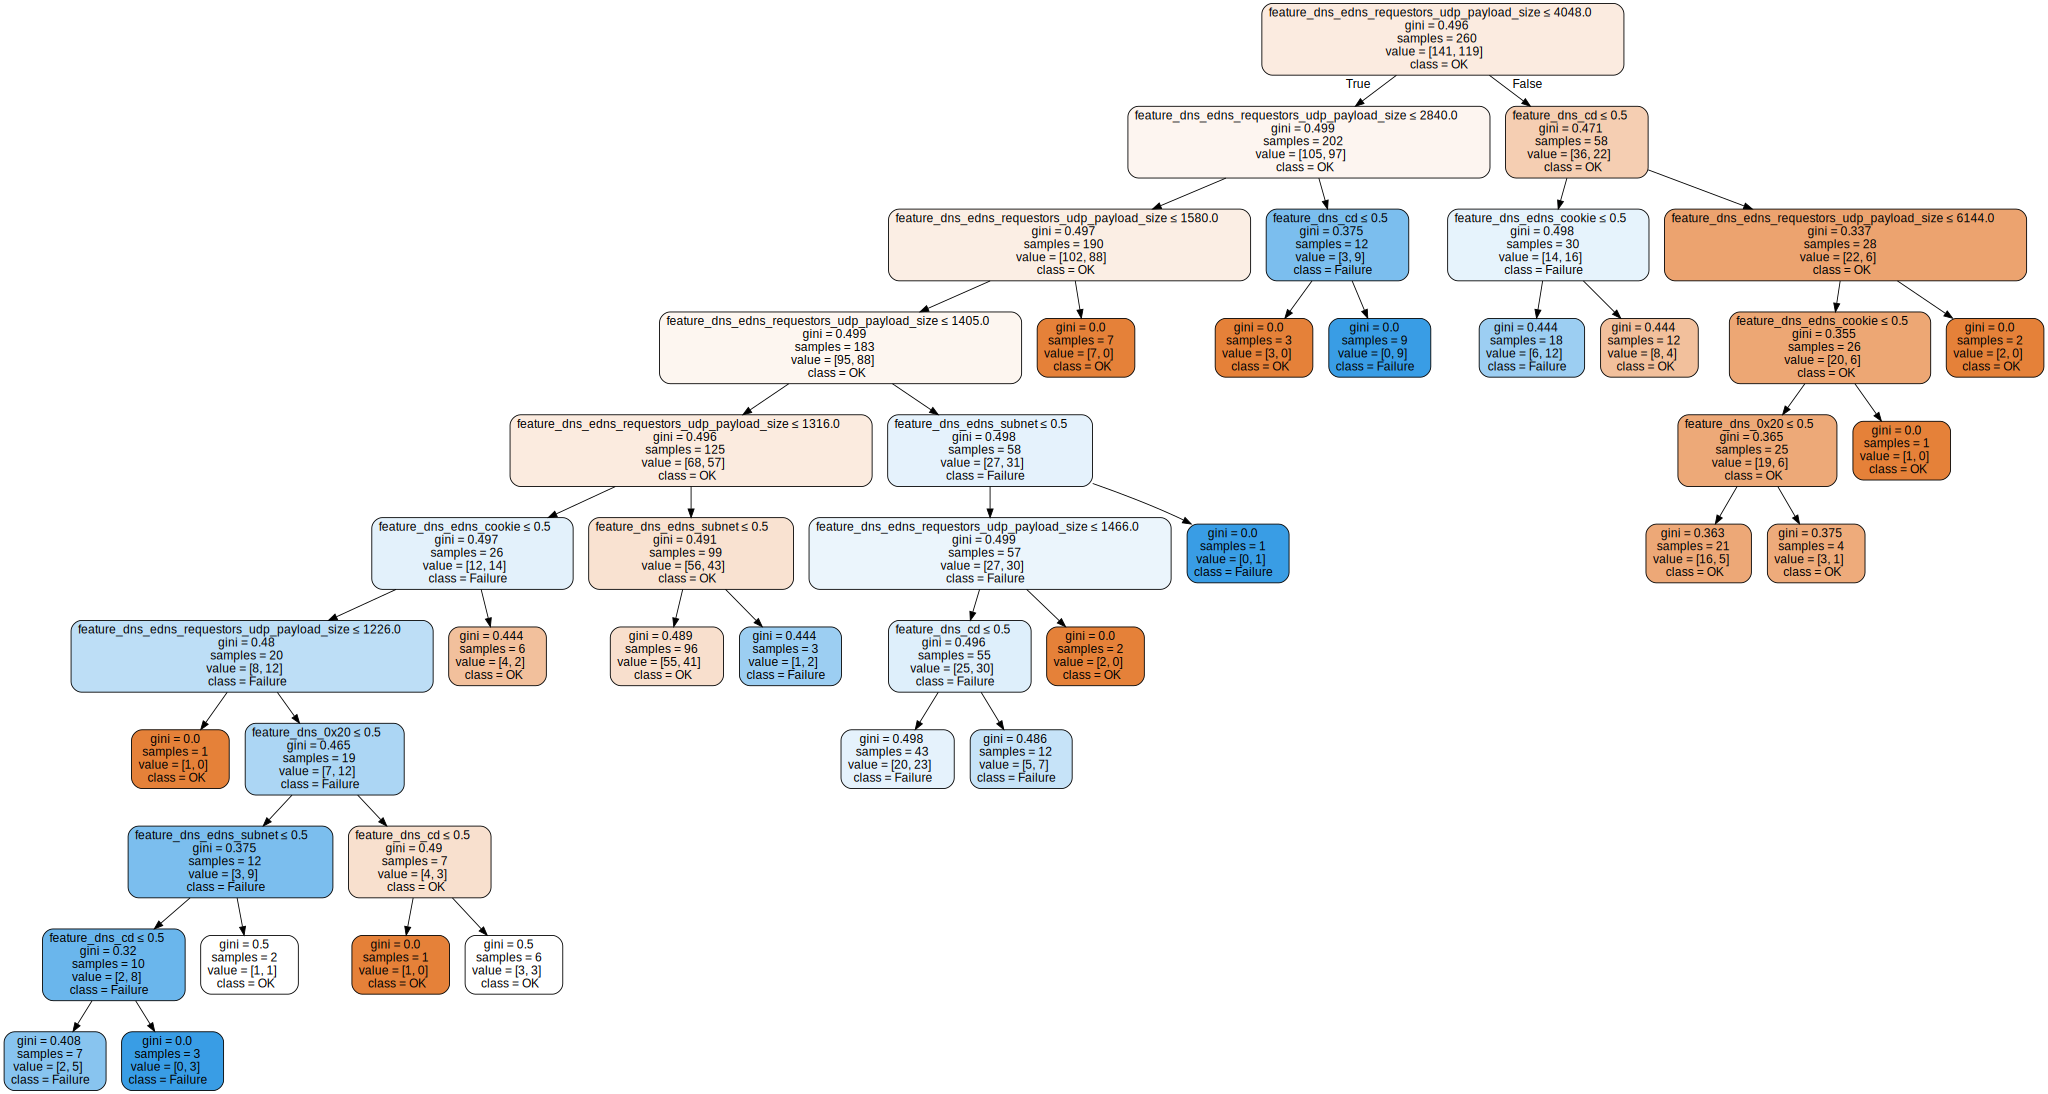

In [20]:
graphs['ecdsap384sha384']

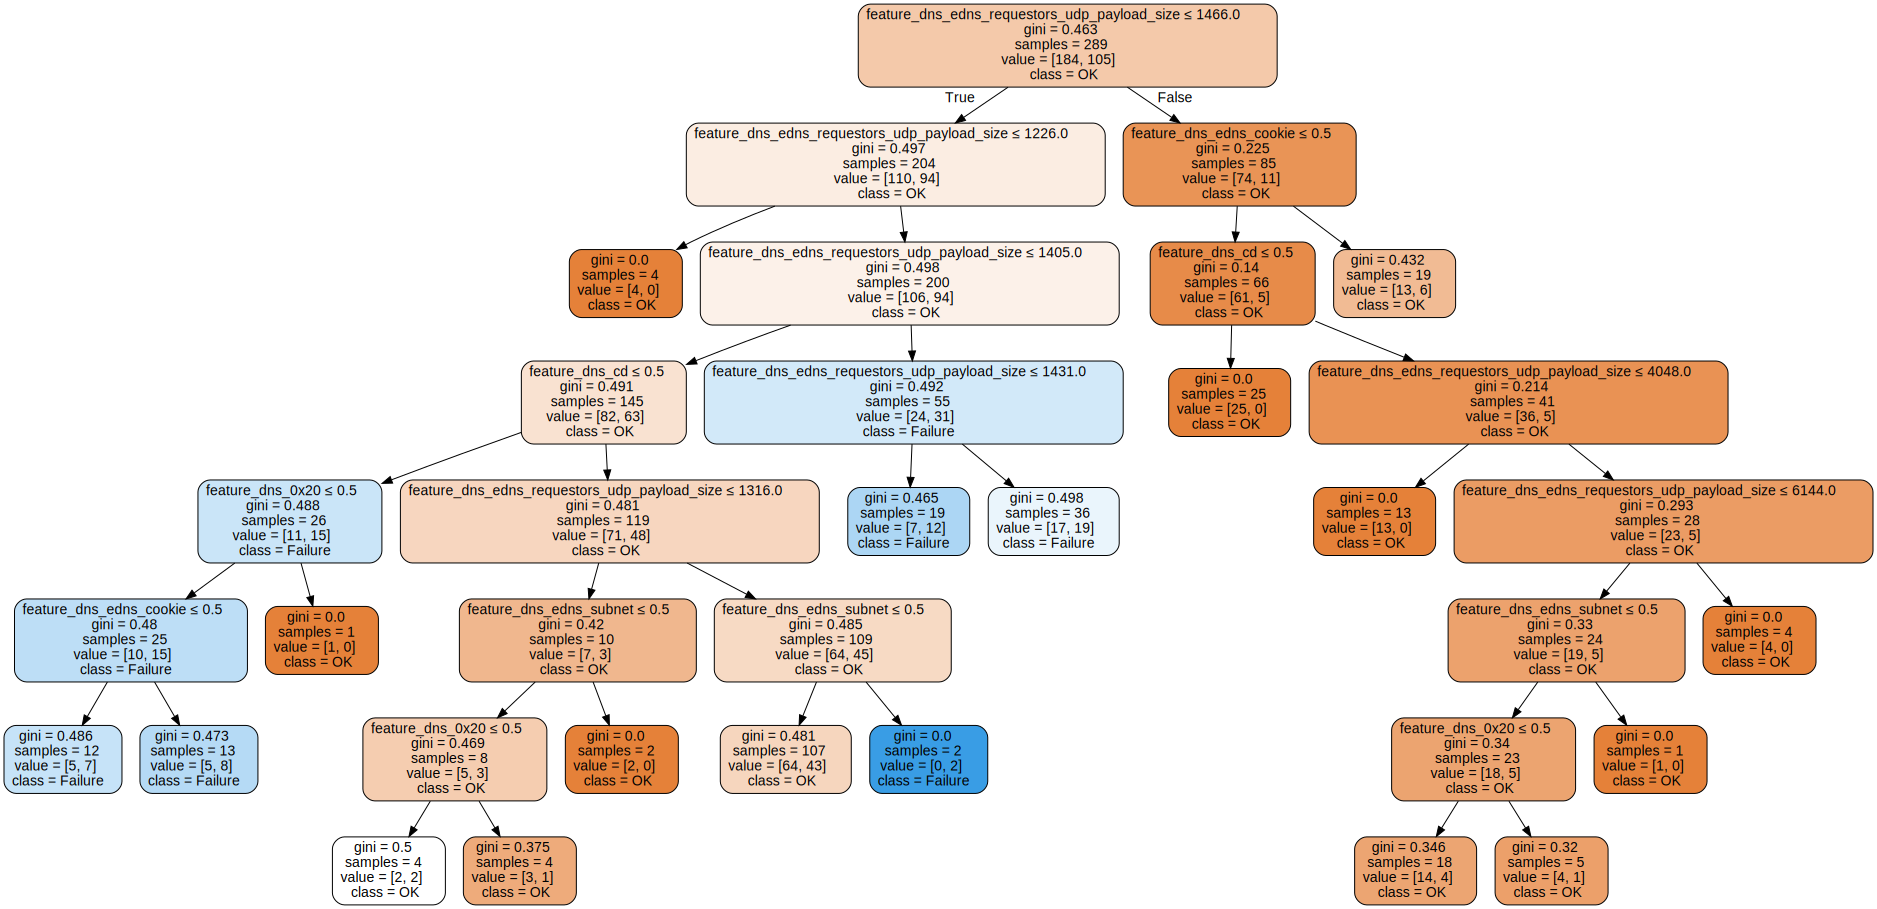

In [21]:
graphs['ed25519']

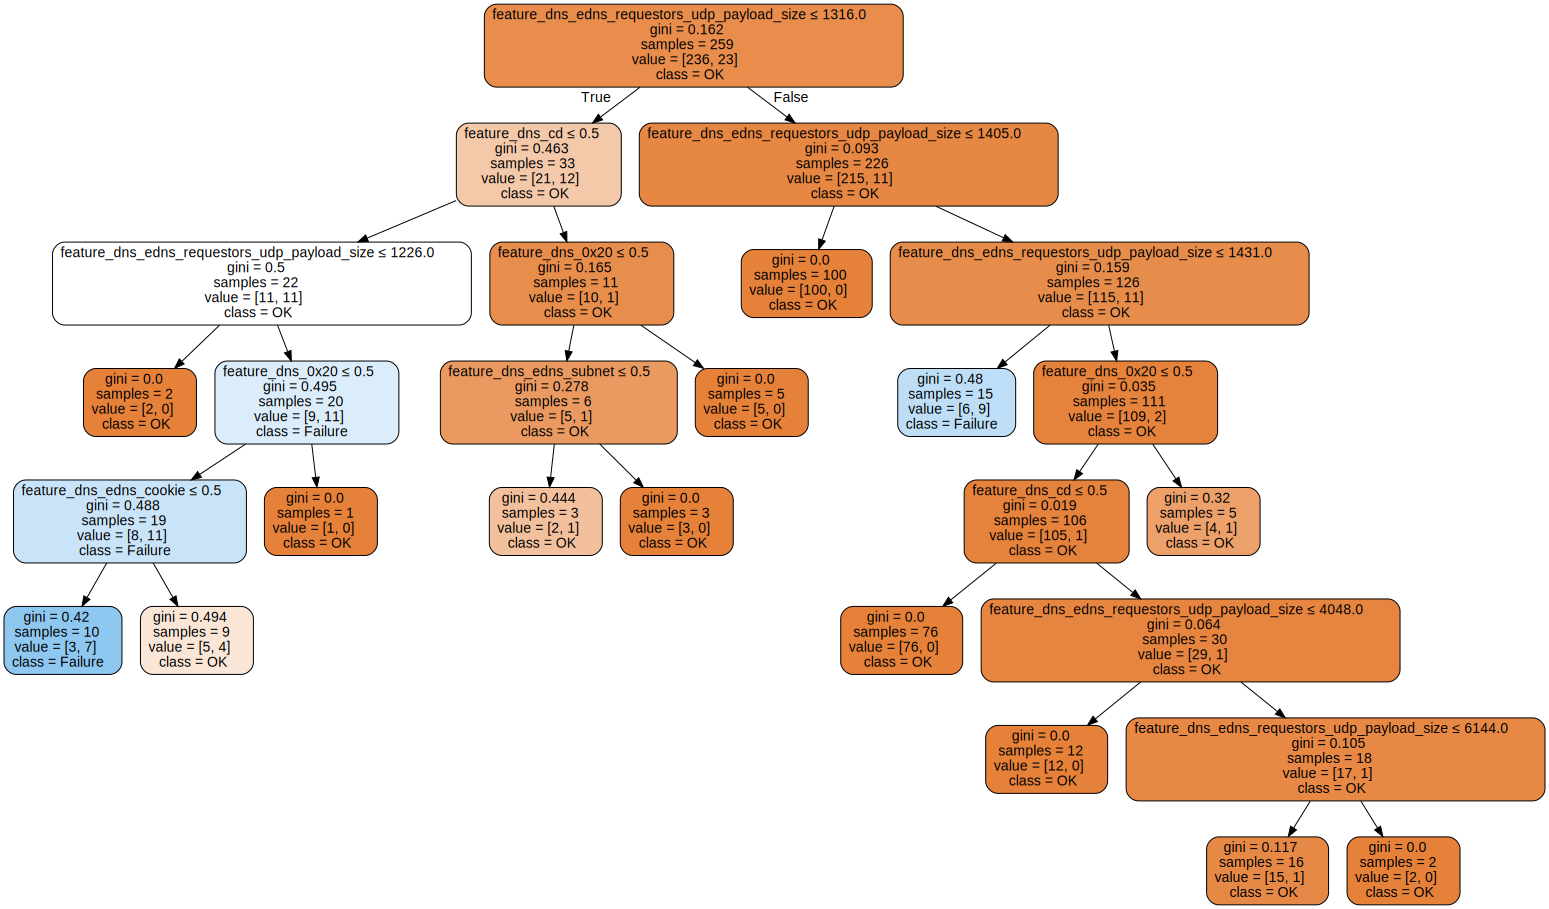

In [22]:
graphs['ed448']

# Predicting Cipher

In [23]:
# putting all data together
fdata = pd.concat([d for d in data.values()])
fdata = fdata[fdata['status'] == 'test']

In [24]:
# predicting for each algorithm
X = fdata[features]
Y = fdata[label]

for algo, t in tree.items():
    fdata[f'pred_{algo}'] = t.predict(X)

In [25]:
# computing choice for each row
fdata['selected'] = priority[-1]
for algo in priority:
    fdata.loc[fdata[f'pred_{algo}'], 'selected'] = algo

In [26]:
fdata[['resolver', 'qname', 'selected'] + [f'pred_{algo}' for algo in priority]]

,resolver,qname,selected,pred_rsasha1,pred_rsasha1nsec3sha1,pred_rsasha256,pred_rsasha512,pred_ecdsap256sha256,pred_ecdsap384sha384,pred_ed25519,pred_ed448
67,cloudflare,b'opn-named-cloudflare-20210624190031.rsasha1-...,ed25519,False,True,True,True,False,True,True,False
88,cloudflare,b'opn-named-cloudflare-20210624190031.rsasha1-...,ed25519,False,True,True,True,False,True,True,False
130,yandex-dns-safe,b'opn-named-yandex-dns-safe-20210624190031.rsa...,ed448,False,False,False,False,False,False,False,False
152,yandex-dns-safe,b'opn-named-yandex-dns-safe-20210624190031.rsa...,ed448,False,False,False,False,False,False,False,False
162,cznic-odvr,b'opn-named-cznic-odvr-20210624190031.rsasha1-...,ecdsap256sha256,False,True,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9293,57-86-146-46,b'opn-anon-57-86-146-46-20210624193008.ed448-4...,rsasha512,False,True,True,True,False,False,False,False
9364,91-227-88-49,b'opn-anon-91-227-88-49-20210624193008.ed448-4...,ed25519,False,True,True,True,False,True,True,False
9486,5-58-132-3,b'opn-anon-5-58-132-3-20210624193008.ed448-456...,ed25519,False,False,False,False,True,False,True,False
9489,5-58-132-3,b'opn-anon-5-58-132-3-20210624193008.ed448-456...,ed25519,False,False,False,False,True,False,True,False


In [27]:
resolver_best = pd.read_pickle('resolver_best.pickle')[('zone_algorithm', 'best_algo')].to_dict()
resolver_best

{'bind9113': 'ecdsap384sha384',
 'kresd532': 'ecdsap384sha384',
 'powerdns460': 'ed448',
 'unbound167': 'ed25519',
 'ws2012': 'ecdsap384sha384',
 'ws2012r2': 'ecdsap384sha384',
 'ws2016': 'ecdsap384sha384',
 'ws2019': 'ecdsap384sha384',
 '103-120-32-111': 'ed25519',
 '103-127-3-238': 'ecdsap384sha384',
 '103-154-156-199': 'ed25519',
 '103-202-54-19': 'ed25519',
 '103-242-13-93': 'ecdsap384sha384',
 '103-35-142-194': 'ed448',
 '103-86-194-99': 'ed25519',
 '109-172-182-158': 'ed25519',
 '12-16-106-240': 'ed25519',
 '12-161-77-225': 'ed25519',
 '12-186-72-223': 'ed25519',
 '12-202-154-41': 'ed25519',
 '12-234-135-40': 'ed25519',
 '12-238-52-97': 'ed25519',
 '12-26-126-64': 'ed25519',
 '149-56-165-119': 'ecdsap384sha384',
 '153-19-182-195': 'ed25519',
 '162-159-25-85': 'ed25519',
 '162-159-36-181': 'ed25519',
 '162-159-46-166': 'ed25519',
 '162-159-46-244': 'ed25519',
 '162-159-50-13': 'ed25519',
 '162-159-56-115': 'ed25519',
 '172-64-36-163': 'ed25519',
 '172-64-47-113': 'ed25519',
 '172-

In [28]:
fdata['best_algo'] = fdata.apply(lambda row: resolver_best.get(row['resolver'], priority[-1]), axis=1)

In [29]:
resolvers = set(resolver_best.keys()) | set(fdata['resolver'].unique())
resolvers_lab = {'bind9113',
 'powerdns460',
 'kresd532',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019'}
resolvers_anon = {r for r in resolvers if r[0] in '0123456789'}
resolvers_named = resolvers - resolvers_anon - resolvers_lab
resolver_order = list(sorted(resolvers_lab)) + list(sorted(resolvers_named) + list(sorted(resolvers_anon)))

In [30]:
# selecting resolvers
resolvers_selected = resolvers_lab | resolvers_named | set(np.random.default_rng(6).choice(list(resolvers_anon), size=10, replace=False))
resolvers_selected = {'172-64-47-12',
 '186-208-9-55',
 '189-50-159-14',
 '190-13-217-160',
 '89-111-43-37',
 'bind9113',
 'cisco-umbrella',
 'cloudflare',
 'comodo-secure-dns',
 'cznic-odvr',
 'freenom-world',
 'google',
 'hurricane-electric',
 'kresd532',
 'neustar-free-recursive',
 'norton-connectsafe',
 'opennic',
 'oracle-dyn',
 'powerdns460',
 'quad9',
 'unbound167',
 'verisgn-public-dns',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019',
 'yandex-dns-safe'}

In [31]:
fdata = fdata[fdata['resolver'].isin(resolvers_selected)]

In [32]:
fdata['best supported'] = fdata.apply(lambda row: resolver_best.get(row['resolver'], None), axis=1)
fdata['pred_num'] = fdata.apply(lambda row: ALGO_NUM[row['selected']], axis=1)
fdata['best_algo_num'] = fdata.apply(lambda row: ALGO_NUM.get(row['best_algo'], None), axis=1)
fdata['correct'] = (fdata['selected'] == fdata['best_algo']).astype(np.float)
fdata['overest.'] = (fdata['pred_num'] > fdata['best_algo_num']).astype(np.float)
fdata['underest.'] = (fdata['pred_num'] < fdata['best_algo_num']).astype(np.float)
fdata['better than recomm.'] = (fdata['pred_num'] > 13).astype(np.float)

In [33]:
fdata = fdata[~fdata['best supported'].isna()]

In [34]:
fdata[['resolver', 'qname', 'selected', 'best supported', 'correct', 'overest.', 'underest.']]

,resolver,qname,selected,best supported,correct,overest.,underest.
67,cloudflare,b'opn-named-cloudflare-20210624190031.rsasha1-...,ed25519,ed25519,1.0,0.0,0.0
88,cloudflare,b'opn-named-cloudflare-20210624190031.rsasha1-...,ed25519,ed25519,1.0,0.0,0.0
162,cznic-odvr,b'opn-named-cznic-odvr-20210624190031.rsasha1-...,ecdsap256sha256,ed25519,0.0,0.0,1.0
180,google,b'opn-named-google-20210624190031.rsasha1-2048...,ed448,ed25519,0.0,1.0,0.0
184,google,b'opn-named-google-20210624190031.rsasha1-4096...,ed25519,ed25519,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1333,172-64-47-12,b'opn-anon-172-64-47-12-20210624192146.ed448-4...,ed25519,ed25519,1.0,0.0,0.0
1549,189-50-159-14,b'opn-anon-189-50-159-14-20210624192146.ed448-...,ed448,ed25519,0.0,1.0,0.0
1556,89-111-43-37,b'opn-anon-89-111-43-37-20210624192146.ed448-4...,ed25519,ed448,0.0,0.0,1.0
4133,190-13-217-160,b'opn-anon-190-13-217-160-20210624192544.ed448...,ed448,ed25519,0.0,1.0,0.0


In [35]:
def list_values(c):
    c = set(c)
    if len(c) == 1:
        return next(iter(c))
    return '(varying)'

def single_value(c):
    c = set(c)
    if len(c) == 0:
        return None
    if len(c) == 1:
        return next(iter(c))
    raise ValueError(set(c))

cipher_selection = fdata[~fdata['best_algo'].isna()].groupby(['resolver']).agg({
    'selected': [list_values],
    'best supported': [single_value],
    'correct': ['mean'],
    'underest.': ['mean'],
    'overest.': ['mean'],
    'better than recomm.': ['mean'],
}).sort_values('resolver', key=lambda r: list(map(lambda e: resolver_order.index(e), r)))
cipher_selection.columns = cipher_selection.columns.droplevel(1)
cipher_selection = cipher_selection.reset_index()
print(cipher_selection.to_latex(
    float_format=lambda f: f"{f:.0%}",
    index=False,
))
cipher_selection.to_csv('cipher_selection.csv')
cipher_selection

\begin{tabular}{lllrrrr}
\toprule
               resolver &         selected &   best supported &  correct &  underest. &  overest. &  better than recomm. \\
\midrule
               bind9113 &  ecdsap256sha256 &  ecdsap384sha384 &       0\% &       100\% &        0\% &                   0\% \\
               kresd532 &        (varying) &  ecdsap384sha384 &       8\% &        92\% &        0\% &                   8\% \\
            powerdns460 &            ed448 &            ed448 &     100\% &         0\% &        0\% &                 100\% \\
             unbound167 &        rsasha512 &          ed25519 &       0\% &       100\% &        0\% &                   0\% \\
                 ws2012 &  ecdsap384sha384 &  ecdsap384sha384 &     100\% &         0\% &        0\% &                 100\% \\
               ws2012r2 &  ecdsap384sha384 &  ecdsap384sha384 &     100\% &         0\% &        0\% &                 100\% \\
                 ws2016 &  ecdsap384sha384 &  ecdsap384sha384 &  

,resolver,selected,best supported,correct,underest.,overest.,better than recomm.
0,bind9113,ecdsap256sha256,ecdsap384sha384,0.000000,1.000000,0.000000,0.000000
1,kresd532,(varying),ecdsap384sha384,0.083333,0.916667,0.000000,0.083333
2,powerdns460,ed448,ed448,1.000000,0.000000,0.000000,1.000000
3,unbound167,rsasha512,ed25519,0.000000,1.000000,0.000000,0.000000
4,ws2012,ecdsap384sha384,ecdsap384sha384,1.000000,0.000000,0.000000,1.000000
5,ws2012r2,ecdsap384sha384,ecdsap384sha384,1.000000,0.000000,0.000000,1.000000
6,ws2016,ecdsap384sha384,ecdsap384sha384,1.000000,0.000000,0.000000,1.000000
7,ws2019,ecdsap384sha384,ecdsap384sha384,1.000000,0.000000,0.000000,1.000000
8,cisco-umbrella,ed448,ed448,1.000000,0.000000,0.000000,1.000000
9,cloudflare,ed25519,ed25519,1.000000,0.000000,0.000000,1.000000
